In [26]:
import sys
sys.path.append("/users/lizihao2/python_pkg/")
sys.path.append("/users/lizihao2/python_pkg/grizli")

import grizli
from astropy.io import fits
import os
import numpy as np
from astropy.table import Table
from multiprocessing import Pool
from jwst.pipeline import calwebb_detector1
import multiprocessing
import glob
from grizli.prep import get_radec_catalog
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
from grizli.prep import process_direct_grism_visit,align_drizzled_image,make_SEP_catalog
from grizli.pipeline import auto_script
from grizli import utils
from grizli.pipeline.default_params import get_yml_parameters
from functools import partial
from grizli import utils, fitting, multifit, prep, model,grismconf
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
utils.set_warnings()

In [2]:
%load_ext autoreload
%autoreload 2

# Grizli NIRCam WFSS reduction tutorial
Author: Zihao Li (zihao.li@nbi.ku.dk)

Date: 10/12/2024

In [3]:
HOME_PATH = '/pfs/lustrep3/scratch/project_465001526/tutorial'
# HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)
root = 'XMM1-Z-1664'

HOME_PATH =  /pfs/lustrep3/scratch/project_465001526/tutorial


In [4]:
# make directories
if not os.path.exists(root):
    os.mkdir(root)
if not os.path.exists(HOME_PATH + '/' + root + '/RAW'):
    os.chdir(HOME_PATH + '/' + root)
    !mkdir RAW
    os.chdir(HOME_PATH)
if not os.path.exists(HOME_PATH + '/' + root + '/Prep'):
    os.chdir(HOME_PATH + '/' + root)
    !mkdir Prep
    os.chdir(HOME_PATH)
if not os.path.exists(HOME_PATH + '/' + root + '/Extractions'):
    os.chdir(HOME_PATH + '/' + root)
    !mkdir Extractions
    os.chdir(HOME_PATH)

# Pipeline processing

In [ ]:
os.chdir(HOME_PATH)
files = glob.glob('%s/RAW/*rate.fits'%root)
p = Pool(4)
p.map(partial(grizli.jwst_utils.set_jwst_to_hst_keywords,reset=True),files)
p.close()
p.join()

# use loops, but slow
# for file in files:
#     _ = grizli.jwst_utils.set_jwst_to_hst_keywords(file, reset=True)

In [5]:
# Preprocessing
# Parameter lists
kwargs = get_yml_parameters()
IS_PARALLEL = False # Set to True for parallel programs like WISPS
visit_prep_args = kwargs['visit_prep_args']
preprocess_args = kwargs['preprocess_args']

# Maximum shift for "tweakshifts" relative alignment
tweak_max_dist = (5 if IS_PARALLEL else 1)
if 'tweak_max_dist' not in visit_prep_args:
    visit_prep_args['tweak_max_dist'] = tweak_max_dist

# Fit and subtract a SExtractor-like background to each visit
visit_prep_args['imaging_bkg_params']  = {'bh': 256, 'bw': 256, 'fh': 3, 'fw': 3, 
                                          'pixel_scale': 0.1, 'get_median': False}

# Alignment reference catalogs, searched in this order
preprocess_args['catalogs'] = ['LS_DR9','PS1','GAIA','SDSS']

visit_prep_args['snowball_kwargs']['mask_bit'] = 1 # mask snowball as DO_NOT_USE
visit_prep_args['drizzle_params']['bits'] = '~512+1' # ~512+1 = ~NONSCIENCE+DO_NOT_USE
visit_prep_args['fix_stars']= True
kwargs['grism_prep_args']['refine_mag_limits'] = [18, 24]
visit_prep_args.pop('align_thresh')

In [6]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

root = 'XMM1-Z-1664'
visits, all_groups, info = auto_script.parse_visits(field_root = root,
                                            RAW_PATH = '../RAW')

# (2024-12-13 12:11:51.202)

auto_script.parse_visits(**{'files': [], 'field_root': 'XMM1-Z-1664', 'RAW_PATH': '../RAW', 'use_visit': True, 'combine_same_pa': True, 'combine_minexp': 2, 'is_dash': False, 'filters': ['F410M', 'F467M', 'F547M', 'F550M', 'F621M', 'F689M', 'F763M', 'F845M', 'F200LP', 'F350LP', 'F435W', 'F438W', 'F439W', 'F450W', 'F475W', 'F475X', 'F555W', 'F569W', 'F600LP', 'F606W', 'F622W', 'F625W', 'F675W', 'F702W', 'F775W', 'F791W', 'F814W', 'F850LP', 'G800L', 'F098M', 'F127M', 'F139M', 'F153M', 'F105W', 'F110W', 'F125W', 'F140W', 'F160W', 'G102', 'G141', 'F070W', 'F090W', 'F1000W', 'F1130W', 'F115W', 'F1280W', 'F140M', 'F1500W', 'F150W', 'F150W2', 'F158M', 'F162M', 'F164N', 'F1800W', 'F182M', 'F187N', 'F200W', 'F2100W', 'F210M', 'F212N', 'F250M', 'F2550W', 'F277W', 'F300M', 'F322W2', 'F323N', 'F335M', 'F356W', 'F360M', 'F380M', 'F405N', 'F410M', 'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M', 'F560W', 'F770W', 'GR150C', 'GR150R', 'GRISMR', 'GRISMC'], 'max_dt': 10

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

auto_script.preprocess(field_root=root, HOME_PATH='HOMEPATH',
                       # skip_imaging=True,
                              visit_prep_args=visit_prep_args, **preprocess_args)  

In [9]:
visits, all_groups, info = auto_script.load_visit_info(root, verbose=True)
# visit_file = auto_script.find_visit_file(root=root)
_ = auto_script.get_visit_exposure_footprints(root=root)

Load visit information from ./XMM1-Z-1664_visits.yaml


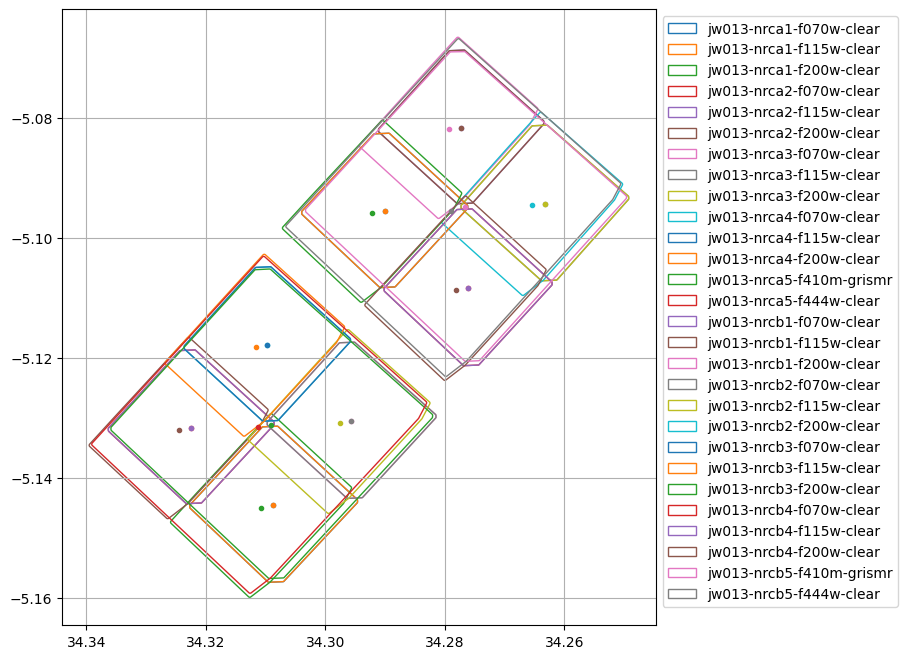

In [48]:
colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
fig, ax = plt.subplots(1,1,figsize=(8,8))
for i, v in enumerate(visits):
    sr = utils.SRegion(v['footprint'])

    ax.scatter(*sr.centroid[0], marker='.', c=colors[i%len(colors)])
    for patch in sr.patch(ec=colors[i%len(colors)], fc='None', alpha=1, 
                          label=v['product']
                         ):
        ax.add_patch(patch)

ax.set_aspect(1./np.cos(ax.get_ylim()[0]/180*np.pi)) # square with cos(dec)
ax.set_xlim(ax.get_xlim()[::-1])
ax.grid()
plt.legend(bbox_to_anchor=(1.,1))
plt.show()

In [49]:
# RGB mosaic
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
# if not os.path.exists('{0}.field.jpg'.format(root)):
slx, sly, rgb_filts, fig = auto_script.field_rgb(root=root, scl=3, HOME_PATH=None,force_rgb=['f444w','f200w','f115w'])  
plt.close(fig)
    


PATH: ./, files: ['./XMM1-Z-1664-f070w_drz_sci.fits', './XMM1-Z-1664-f115w_drz_sci.fits', './XMM1-Z-1664-f200w_drz_sci.fits', './XMM1-Z-1664-f444w_drz_sci.fits']
Failed: .//XMM1-Z-1664-ir_dr?_sci.fits
# field_rgb XMM1-Z-1664: r f444w / g f200w / b f115w
# field_rgb scl=3.00 / r 1.00 / g 1.00 / b 1.00


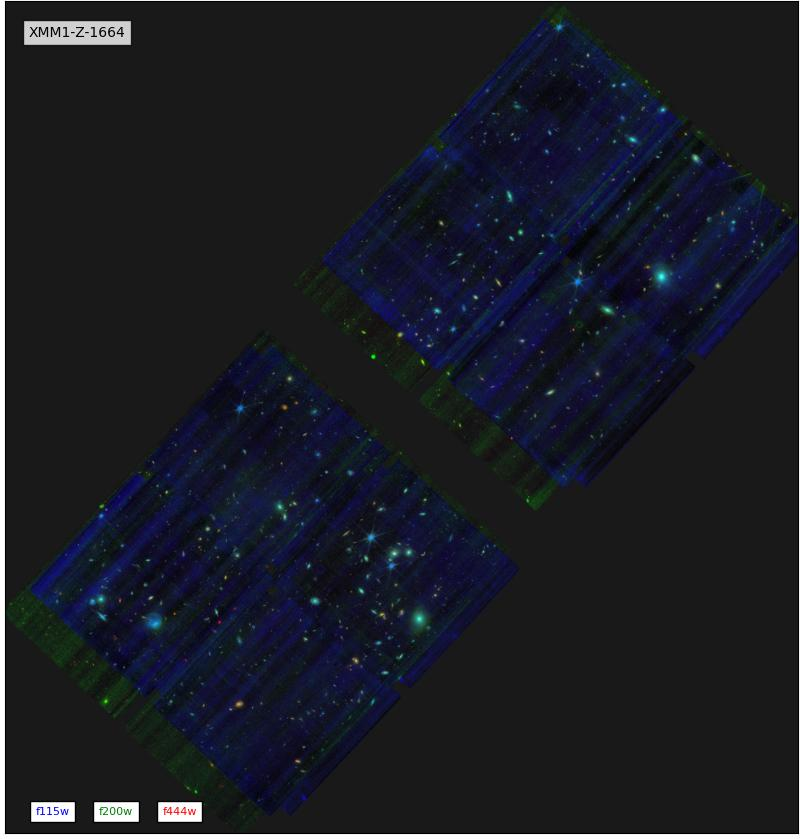

In [50]:
Image(filename='{0}.field.jpg'.format(root))

In [22]:
mosaic_drizzle_args = kwargs['mosaic_drizzle_args']
mosaic_args = kwargs['mosaic_args']

mosaic_args['fill_mosaics'] = False
mosaic_args['wcs_params']['pixel_scale'] = 0.031
mosaic_args['mosaic_pixfrac'] = 1
mosaic_args['half_optical_pixscale'] = False

mosaic_args['wcs_params']['pad_reference'] = 6 # small padding around edge, arcsec
mosaic_args['ir_filters'] = ['F070W','F115W','F200W','F444W']
mosaic_drizzle_args['static'] = False
mosaic_drizzle_args['skysub'] = True
mosaic_drizzle_args['bits'] = '~1+512'
mosaic_drizzle_args['combine_type'] = 'median'
mosaic_drizzle_args['crbit'] = 4096+2048
mosaic_drizzle_args['resetbits'] = 2048
# mosaic_drizzle_args['final_wht_type'] = 'IVM'
mosaic_drizzle_args['skymethod'] = 'localmin'
mosaic_drizzle_args['align_north'] = True

In [25]:
mosaic_drizzle_args.pop('final_wht_type')

'IVM'

# Make combined mosaics for each available filter

In [ ]:
auto_script.make_combined_mosaics(root, mosaic_driz_cr_type=2,mosaic_args=mosaic_args, 
                          mosaic_drizzle_args=mosaic_drizzle_args,fix_stars=True)

In [ ]:
# auto_script.make_filter_combinations('SMACS0723', weight_fnu=True, min_count=1,
#         filter_combinations={'ir': ['F115W','F150W','F200W','F277W','F356W','F444W']})

# Generate a photometric catalog
Run source detection on the combined mosaic {root}-ir_dr[cz]_sci.fits and generates a catalog and segmentation image.

Then perform simple matched-aperture photometry on the different available filter mosaics (in this case F098M and F140W from the direct imaging). In principle the template fitting code shown below can incorporate this photometric information, though that's not currently done by default.

In [7]:
utils.set_warnings()
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
detection_params={'minarea': 9, 'filter_kernel': np.array([[ 0.005,  0.021,  0.051,  0.069,  0.051,  0.021,  0.005],
       [ 0.021,  0.092,  0.221,  0.296,  0.221,  0.092,  0.021],
       [ 0.051,  0.221,  0.531,  0.711,  0.531,  0.221,  0.051],
       [ 0.069,  0.296,  0.711,  0.951,  0.711,  0.296,  0.069],
       [ 0.051,  0.221,  0.531,  0.711,  0.531,  0.221,  0.051],
       [ 0.021,  0.092,  0.221,  0.296,  0.221,  0.092,  0.021],
       [ 0.005,  0.021,  0.051,  0.069,  0.051,  0.021,  0.005]]),
                  'filter_type': 'conv', 'clean': True,
                  'clean_param': 1, 'deblend_nthresh': 20,
                  'deblend_cont': 0.01}

phot = auto_script.multiband_catalog(field_root=root, detection_filter='f444w',
                                     get_all_filters=True,threshold=2.5,
                                     detection_params=detection_params)

# (2024-12-10 09:17:06.856)

auto_script.multiband_catalog(**{'threshold': 2.5, 'detection_background': True, 'photometry_background': True, 'get_all_filters': True, 'filters': None, 'det_err_scale': -inf, 'phot_err_scale': -inf, 'rescale_weight': True, 'run_detection': True, 'detection_filter': 'f444w', 'detection_root': None, 'output_root': None, 'use_psf_filter': True, 'detection_params': {'minarea': 9, 'filter_kernel': array([[0.005, 0.021, 0.051, 0.069, 0.051, 0.021, 0.005],
       [0.021, 0.092, 0.221, 0.296, 0.221, 0.092, 0.021],
       [0.051, 0.221, 0.531, 0.711, 0.531, 0.221, 0.051],
       [0.069, 0.296, 0.711, 0.951, 0.711, 0.296, 0.069],
       [0.051, 0.221, 0.531, 0.711, 0.531, 0.221, 0.051],
       [0.021, 0.092, 0.221, 0.296, 0.221, 0.092, 0.021],
       [0.005, 0.021, 0.051, 0.069, 0.051, 0.021, 0.005]]), 'filter_type': 'conv', 'clean': True, 'clean_param': 1, 'deblend_nthresh': 20, 'deblend_cont': 0.01}, 'phot_apertures': [<Quantity 0.36 arcsec>, <Quantity 0.500001 a

In [12]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

files = glob.glob('*GrismFLT.fits')

if len(files) == 0:
    ### Grism contamination model

    # Which filter to use as direct image?  Will try in order of the list until a match is found.
    grism_prep_args = kwargs['grism_prep_args']
    
    grism_prep_args['gris_ref_filters'] = {'GRISMR': ['F444W'],
                                           'GRISMC': ['F444W']}
    grism_prep_args['refine_mag_limits'] = [12,22]
    grism_prep_args['prelim_mag_limit'] = 22
    grism_prep_args['mask_mosaic_edges'] = False
    grism_prep_args['pad'] = [50,800]
    grism_prep_args['mask_mosaic_edges'] = False
    grism_prep_args['force_ref'] = 'XMM1-Z-1664-f444w_drz_sci.fits'
    grism_prep_args['force_cat'] = 'XMM1-Z-1664-f444w.cat.fits'
    grism_prep_args['force_seg'] = 'XMM1-Z-1664-f444w_seg.fits'
    grp = auto_script.grism_prep(field_root=root, **grism_prep_args)

    
else:
    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='XMM1-Z-1664-f444w.cat.fits', 
                            cpu_count=-1, sci_extn=1, pad=[50,800])

# (2024-12-13 12:39:57.263)

auto_script.grism_prep(**{'field_root': 'XMM1-Z-1664', 'PREP_PATH': '../Prep', 'EXTRACT_PATH': '../Extractions', 'ds9': None, 'refine_niter': 3, 'gris_ref_filters': {'GRISMR': ['F444W'], 'GRISMC': ['F444W']}, 'force_ref': 'XMM1-Z-1664-f444w_drz_sci.fits', 'force_cat': 'XMM1-Z-1664-f444w.cat.fits', 'force_seg': 'XMM1-Z-1664-f444w_seg.fits', 'files': None, 'split_by_grism': True, 'refine_poly_order': 3, 'refine_fcontam': 0.5, 'cpu_count': 0, 'mask_mosaic_edges': False, 'prelim_mag_limit': 22, 'refine_mag_limits': [12, 22], 'init_coeffs': [1.1, -0.5], 'grisms_to_process': None, 'pad': [50, 800], 'model_kwargs': {'compute_size': True}, 'sep_background_kwargs': None, 'subtract_median_filter': False, 'median_filter_size': 71, 'median_filter_central': 10, 'second_pass_filtering': False, 'box_filter_sn': 3, 'box_filter_width': 3, 'median_mask_sn_threshold': None, 'median_mask_dilate': 8, 'prelim_model_for_median': False, 'use_jwst_crds': False})

auto_script.grism_

2024-12-13 14:41:54,457 - stpipe - WARNING - /LUMI_TYKKY_YnFw3rV/miniconda/envs/env1/lib/python3.9/site-packages/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to    87.673457 from OBSGEO-[XYZ].
Set OBSGEO-B to    12.325800 from OBSGEO-[XYZ].
Set OBSGEO-H to 1678148258.255 from OBSGEO-[XYZ]'.
  warnings.warn(

2024-12-13 14:41:54,463 - stpipe - WARNING - /LUMI_TYKKY_YnFw3rV/miniconda/envs/env1/lib/python3.9/site-packages/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to    87.672660 from OBSGEO-[XYZ].
Set OBSGEO-B to    12.326776 from OBSGEO-[XYZ].
Set OBSGEO-H to 1678137844.806 from OBSGEO-[XYZ]'.
  warnings.warn(

2024-12-13 14:41:54,471 - stpipe - WARNING - /LUMI_TYKKY_YnFw3rV/miniconda/envs/env1/lib/python3.9/site-packages/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to    87.672660 from OBSGEO-[XYZ].
Set OBSGEO-B to    12.326777 from OBSGEO-[XYZ].
Set OBSGEO-H to 1678137841.451 

jw06480013001_03101_00002_nrcblong_rate.fits: _compute_model Done
jw06480013001_03101_00001_nrcalong_rate.fits: _compute_model Done
jw06480013001_03101_00002_nrcalong_rate.fits: _compute_model Done
jw06480013001_03101_00001_nrcblong_rate.fits: _compute_model Done
jw06480013001_03101_00003_nrcalong_rate.fits: _compute_model Done
jw06480013001_03101_00003_nrcblong_rate.fits: _compute_model Done
jw06480013001_03101_00004_nrcblong_rate.fits: _compute_model Done
jw06480013001_03101_00004_nrcalong_rate.fits: _compute_model Done
jw06480013001_03103_00001_nrcalong_rate.fits: _compute_model Done
jw06480013001_03103_00001_nrcblong_rate.fits: _compute_model Done
jw06480013001_03103_00003_nrcblong_rate.fits: _compute_model Done
jw06480013001_03103_00004_nrcalong_rate.fits: _compute_model Done
jw06480013001_03103_00002_nrcalong_rate.fits: _compute_model Done
jw06480013001_03103_00002_nrcblong_rate.fits: _compute_model Done
jw06480013001_03103_00003_nrcalong_rate.fits: _compute_model Done
jw06480013

ln: failed to create symbolic link './jw06480013001_03101_00001_nrcalong.01.GrismFLT.fits': File exists
ln: failed to create symbolic link './jw06480013001_03101_00001_nrcalong.01.GrismFLT.pkl': File exists
ln: failed to create symbolic link './jw06480013001_03101_00001_nrcblong.01.GrismFLT.fits': File exists
ln: failed to create symbolic link './jw06480013001_03101_00001_nrcblong.01.GrismFLT.pkl': File exists
ln: failed to create symbolic link './jw06480013001_03101_00002_nrcalong.01.GrismFLT.fits': File exists
ln: failed to create symbolic link './jw06480013001_03101_00002_nrcalong.01.GrismFLT.pkl': File exists
ln: failed to create symbolic link './jw06480013001_03101_00002_nrcblong.01.GrismFLT.fits': File exists
ln: failed to create symbolic link './jw06480013001_03101_00002_nrcblong.01.GrismFLT.pkl': File exists
ln: failed to create symbolic link './jw06480013001_03101_00003_nrcalong.01.GrismFLT.fits': File exists
ln: failed to create symbolic link './jw06480013001_03101_00003_nrca

# Spectra extraction

In [21]:
os.chdir('../Extractions')
pline = {'kernel': 'square', 'pixfrac': 1, 'pixscale': 0.03, 'size': 4, 'wcs': None}

args = auto_script.generate_fit_params(field_root=root, 
                                       prior=None,  
                                       pline=pline, 
                                       fit_only_beams=True, 
                                       run_fit=True, 
                                       poly_order=7, 
                                       fsps=True, 
                                       sys_err = 0.03, 
                                       fcontam=0.2, 
                                       zr=[0.05, 9], dz=[0.05, 0.005],include_photometry=False, use_phot_obj=False,
                                       save_file='fit_args.yaml')



# thread = multiprocessing.Process(target=auto_script.extract,
#                                  kwargs={'field_root':'C3D-17','maglim':[10,28],
#                                 'pline':pline, 'run_fit':False, 'grp':grp,
#                                 'diff':True,'skip_complete':True,'size':30,
#                                 'oned_R':False,'args_file':'fit_args.yaml.npy'})
# thread.start()

Saved arguments to fit_args.yaml.


In [27]:
auto_script.extract(ids=[1918],field_root=root,
                    pline=pline, run_fit=False, grp=grp,
                    diff=True,skip_complete=False,size=40,
                    oned_R=False,args_file='fit_args.yaml.npy')

0/1: 1918 8


2024-12-13 17:11:50,182 - stpipe - INFO - -Drizzling using kernel = point
2024-12-13 17:11:50,182 - stpipe - INFO - 
2024-12-13 17:11:50,184 - stpipe - INFO - -Drizzling using kernel = point
2024-12-13 17:11:50,184 - stpipe - INFO - 
2024-12-13 17:11:50,192 - stpipe - INFO - -Drizzling using kernel = point
2024-12-13 17:11:50,193 - stpipe - INFO - 
2024-12-13 17:11:50,194 - stpipe - INFO - -Drizzling using kernel = point
2024-12-13 17:11:50,195 - stpipe - INFO - 
2024-12-13 17:11:50,202 - stpipe - INFO - -Drizzling using kernel = point
2024-12-13 17:11:50,202 - stpipe - INFO - 
2024-12-13 17:11:50,204 - stpipe - INFO - -Drizzling using kernel = point
2024-12-13 17:11:50,204 - stpipe - INFO - 
2024-12-13 17:11:50,212 - stpipe - INFO - -Drizzling using kernel = point
2024-12-13 17:11:50,212 - stpipe - INFO - 
2024-12-13 17:11:50,214 - stpipe - INFO - -Drizzling using kernel = point
2024-12-13 17:11:50,214 - stpipe - INFO - 
2024-12-13 17:11:50,222 - stpipe - INFO - -Drizzling using kerne

XMM1-Z-1664_01918.beams.fits


True

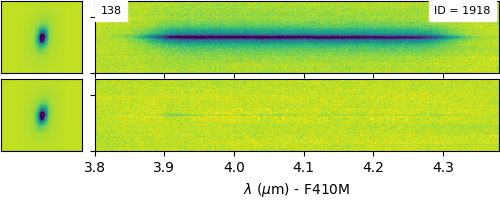

In [28]:
from IPython.display import Image

ID = 1918
Image(filename='{0}_{1:05d}.stack.png'.format(root, ID))

In [3]:
# cat = Table.read('XMM1-Z-1664/Prep/XMM1-Z-1664_phot.fits')

In [33]:
from astropy.visualization import ImageNormalize, ZScaleInterval,ManualInterval, LogStretch, LinearStretch


def show_model(flt,num,ylim=None,**imshow_kwards):
    
    grism_shape = flt.grism['SCI'].shape
    ref_shape = flt.direct.data['REF'].shape
    im_list = [flt.grism['SCI'],flt.model,flt.grism['SCI']-flt.model]
    fig,ax = plt.subplots(1,4,figsize=(14,3),sharey='all')
    plt.subplots_adjust(wspace=0.05)
    
    zshow(flt.direct.data['REF'],ax=ax[0],**imshow_kwards)
    ax[0].set_xlim(flt.pad[1],grism_shape[1]-flt.pad[1])
    ax[0].set_ylim(flt.pad[0],grism_shape[0]-flt.pad[0])
    titles = ['Direct','Grism','Model','Residual']
    

    vm = [-0.01, 0.09]
    for i,im in enumerate(im_list):
        ax[i+1].imshow(im, vmin=vm[0], vmax=vm[1],
                  interpolation='Nearest', origin='lower',**imshow_kwards)

        ax[i+1].set_xlim(flt.pad[1],grism_shape[1]-flt.pad[1])
        ax[i+1].set_ylim(flt.pad[0],grism_shape[0]-flt.pad[0])
        
    for i in range(4):
        ax[i].set_title(titles[i])
        # plt.setp(ax[i+1].get_yticklabels(), visible=False)
        
        
    # ax[1].set_yticks([])
    # ax[2].set_yticklabels([])
    # ax[3].set_yticklabels([])

    
    flt.catalog.add_index('NUMBER')
    idx = np.argsort(flt.catalog['MAG_AUTO'])[:num]

    
    hr = fits.getheader('../Prep/'+flt.grism_file)
    plt.suptitle(hr['PUPIL']+' Module '+flt.grism_file.split('nrc')[1][0])
    ax[0].scatter(flt.catalog['x_flt'][idx]+1,flt.catalog['y_flt'][idx]+1,s=50, facecolors='none', edgecolors='r')
        
    for n in idx:
        
        x0 = flt.catalog['x_flt'][n]+1
        y0 = flt.catalog['y_flt'][n]+1
        
        if (x0 > grism_shape[1]-flt.pad[1])|(x0<flt.pad[1]):
            continue
        dx = flt.conf.dxlam['A']
        dy, lam = flt.conf.get_beam_trace(x=x0-flt.pad[1], y=y0-flt.pad[0], dx=dx, beam='A')
        xint = np.interp(np.arange(3.8,4.3,0.1), lam/1.e4, dx)
        yint = np.interp(np.arange(3.8,4.3,0.1), lam/1.e4, dy)
        lamint = np.interp(np.arange(3.8,4.3,0.1), lam/1.e4, lam)/1e4
            
        ax[1].plot(x0+dx-1, y0+dy-1, color='red', linewidth=1, alpha=0.5)
        ax[1].scatter(x0+xint-1, y0+yint-1, marker='o', color='red', alpha=0.5,s=3)
        
        # ax[2].plot(x0+dx-1, y0+dy-1, color='red', linewidth=1, alpha=0.5)
        # ax[2].scatter(x0+xint-1, y0+yint-1, marker='o', color='red', alpha=0.5,s=3)
        
        if ylim:
            if (y0+yint[-1]>ylim[1])|(y0+yint[-1]<ylim[0]):
                continue
            else:
                ax[0].text(x0+xint[0]+50, y0+yint[0]+50,flt.catalog['NUMBER'][n],color='r',size=8,)
        else:
            ax[0].text(x0+xint[0]+50, y0+yint[0]+50,flt.catalog['NUMBER'][n],color='r',size=8,)
        
    if ylim:
        ax[0].set_ylim(ylim)
        
    plt.show()
        
def zshow(img,ax=None,**kwards):
    from astropy.visualization import ImageNormalize, ZScaleInterval,ManualInterval, LogStretch, LinearStretch
    norm = ImageNormalize(img, interval=ZScaleInterval())
    if ax:
        im = ax.imshow(img,norm=norm,**kwards)
        return im
    else:
        plt.imshow(img,norm=norm,**kwards)
        
    return 

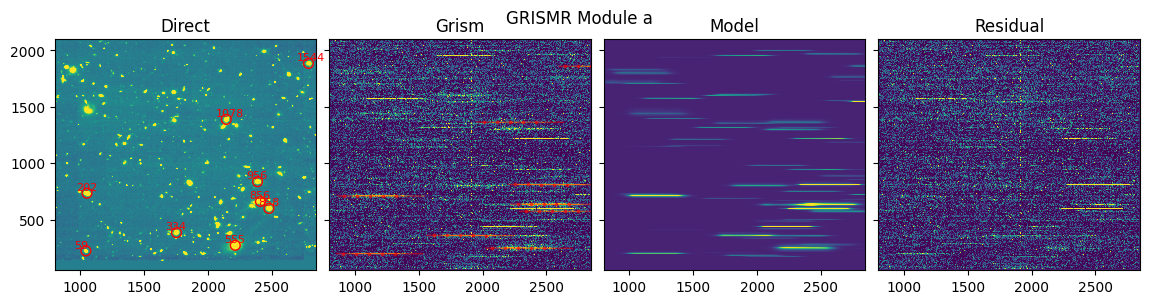

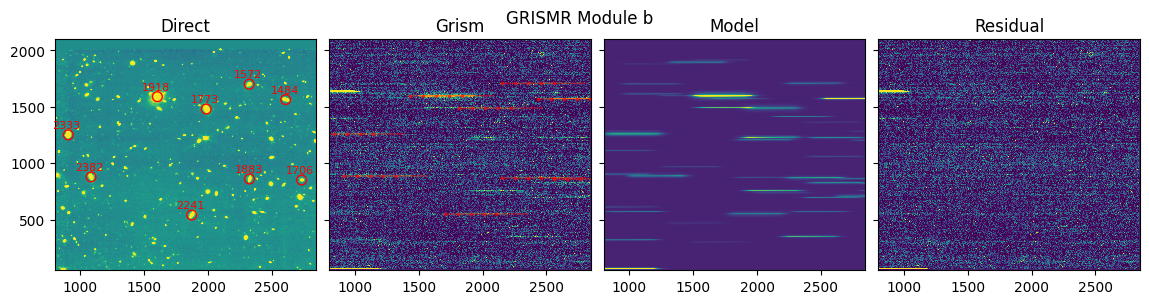

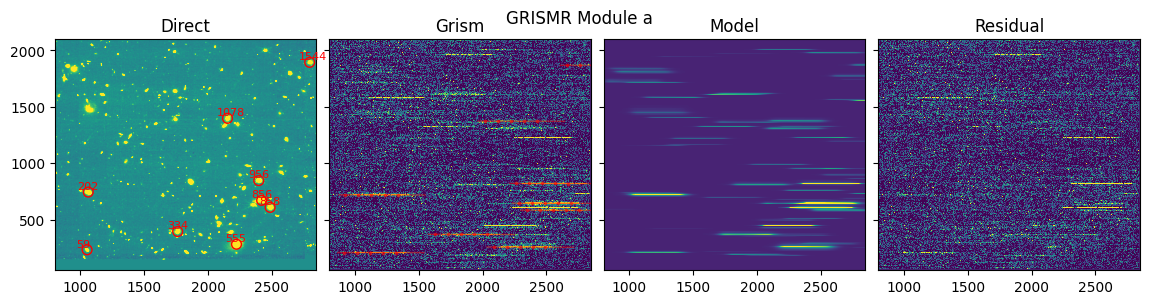

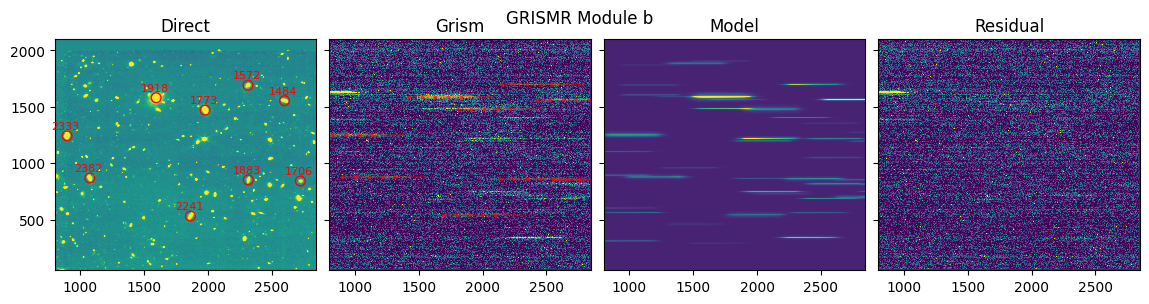

In [34]:
for flt in grp.FLTs[:4]:
    show_model(flt,num=10,aspect='auto')

jw06480013001_03101_00001_nrcalong_rate.fits


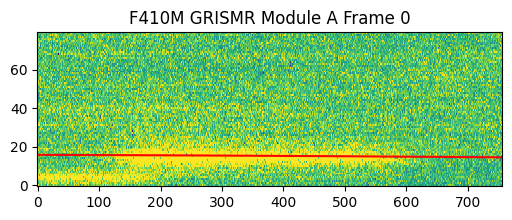

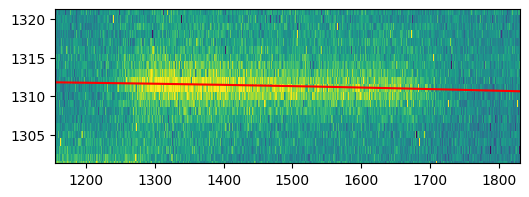

--------
jw06480013001_03101_00002_nrcalong_rate.fits


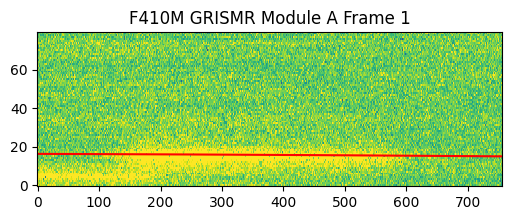

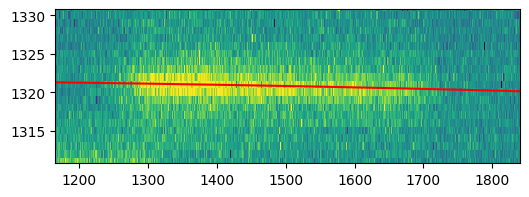

--------
jw06480013001_03101_00003_nrcalong_rate.fits


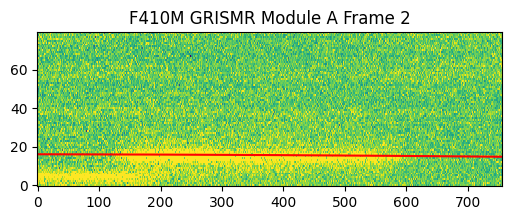

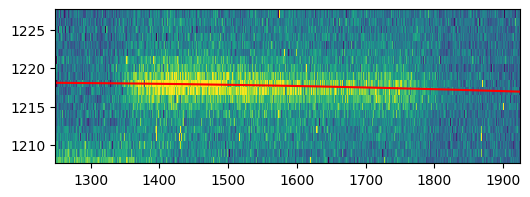

--------
jw06480013001_03101_00004_nrcalong_rate.fits


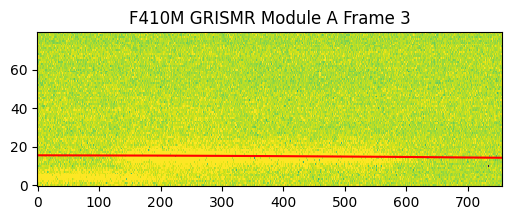

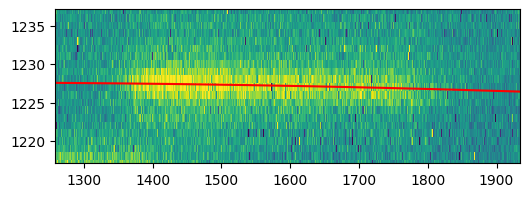

--------
jw06480013001_03103_00001_nrcalong_rate.fits


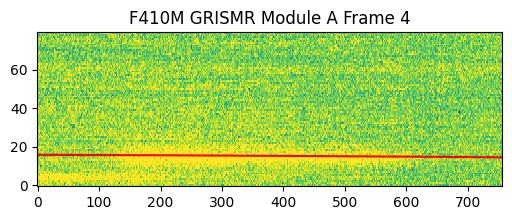

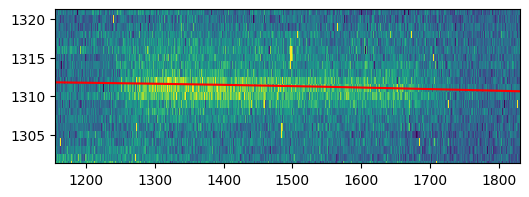

--------
jw06480013001_03103_00002_nrcalong_rate.fits


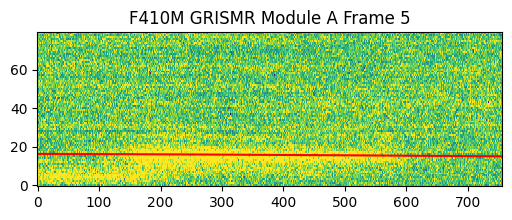

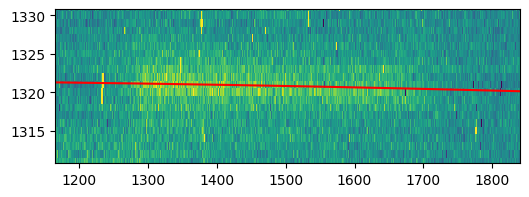

--------
jw06480013001_03103_00003_nrcalong_rate.fits


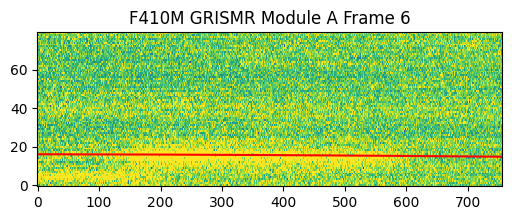

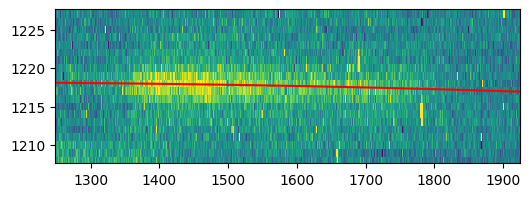

--------
jw06480013001_03103_00004_nrcalong_rate.fits


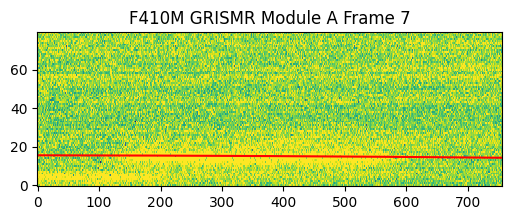

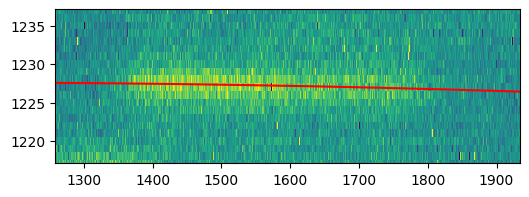

--------


In [30]:
beams = grp.get_beams(1078,size=40)
grp.catalog.add_index('NUMBER')
for i,beam in enumerate(beams):
# beam = beams[i]
    
    plt.figure(figsize=(6,2))
    plt.imshow(beam.grism.data['SCI'],aspect='auto',origin='lower',vmax=0.05,interpolation='None')
    print(beam.grism.parent_file)
    plt.plot(np.arange(np.shape(beam.grism.data['SCI'])[1]),beam.trace_table['trace'],color='r',)
    plt.title(beam.grism.filter+' '+beam.grism.pupil+' Module '+beam.grism.module+f' Frame {i}')
    # plt.ylim(0,30)
    # plt.ylim(25,50)

    plt.show()

    file = os.path.join('../Prep/',beam.grism.parent_file)
    hdr = fits.getheader(file)
    filt = hdr['filter']
    mod = hdr['module']
    pupil = hdr['pupil']
    conf = grismconf.TransformGrismconf(f'/projappl/project_465001526/grizli_config/CONF/GRISM_NIRCAM/V9/NIRCAM_{filt}_mod{mod}_{pupil[-1]}.conf')
    conf.get_beams()
    this_row = grp.catalog.loc[beam.beam.id]
    ID = this_row['NUMBER']
    rot = 0 if mod == 'A' else 2
    
    hdu = fits.open(file)

    coord = SkyCoord(this_row['RA']*u.deg,this_row['DEC']*u.deg)
    hdr = hdu['SCI'].header
    hdr,_,_ = utils.sip_rot90(hdr,rot)
    wcs = WCS(hdr)

    x,y = wcs.world_to_pixel(coord)
    if (x>2048)|(x<0)|(y>2048)|(y<0):
        continue
    # else:
    #     print(x+800,y+50)
    dx = conf.dxlam['A']
    # dx = np.arange(xlim[0],xlim[1])
    dy,lam = conf.get_beam_trace(x,y,dx)
    plt.figure(figsize=(6,2))
    plt.plot(x+dx,y+dy,c='r')
    # ylim = conf.conf['BEAM{0}'.format('A')]
    # dy = np.arange(ylim[0],ylim[1])
    # dx,lam = conf.get_beam_trace(x,y,dy)
    # plt.plot(x-dx,y-dy,c='r')
    data = hdu['SCI'].data
    # dq = hdu['DQ'].data
    # data[(dq&512!=0)|(dq&1!=0)|(dq&1024!=0)|(dq&2048!=0)] = np.nan
    zshow(np.rot90(data,rot),origin='lower',interpolation='None',aspect='auto')

    plt.xlim(np.min(x+dx),np.max(x+dx))
    plt.ylim(y+dy.mean()-10,y+dy.mean()+10)
    plt.show()
    hdu.close()
    print('--------')